# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Where to open a mid-range Restaurant in the suburbs of North Dallas

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

There is a saying in Marketing that states that the three most important aspects for a retail business to be successful are: location, location, location.  While it is true that customer visits to any retail shop will very much dependent on being in right place: well communicated, nice neighborhood and proximity to other retail business or shopping centers, the reality in North Dallas is a bit different.

 Unlike most European or some US cities where there is public transport and neighborhoods are designed to be “walkable”, the suburbs in North Dallas are 100% car dependant.  Distances from houses and shopping centers or business are very large and people need, most of the times, a car to move around. Commercial centers are designed to cluster a number of business (restaurants, grocery stores, shops) and have large parking lots so customers can park their cars with no issue. With that in mind, the problem of finding a good spot for a restaurant, will not be so dependent on the actual distance from the houses or offices as you will have to get there by car anyway.
 
The geographical areas covered in this study will be **Plano, Frisco and McKinney**. These cities are located in the North of Dallas and have been growing economically in the past decades, which made them good candidates to place a restaurant. For this project, the factors that will play a role in determining the ideal location for a midrange Restaurant are the following:
1.	**Proximity to other successful midrange restaurants** will represent competition and will influence negatively the location 
2.	**Proximity to other businesses** (groceries, shops, etc) or low range restaurants are regarded as non competition and therefore a positive influence as they will generate customer traffic to the spot.
3.	**Population density**: the more population residing at a reasonable distance from the restaurant, the more chances to convert to customers
4.	**Population affluency**: the higher household income, the more disposable money to spend in a good middle restaurant. Since fine dining can be considered a non essential expenditure, average income in the area plays a role too.



## Data <a name="data"></a>

Data regarding points 1. And 2. can be obtained through Foursquare with any level of granularity and will be used to get information about restaurants and businesses in a given location. For points 3. and 4. there is no available source of information that can provide average income or population with any level of granularity. However, there are some sources that provide demographic information at zip/suburb level. These sources will be used to gather data about points 3. and 4:
1.	https://www.zip-codes.com/ lists the zip codes that belong to the cities in scope:
a.	Plano https://www.zip-codes.com/city/tx-plano.asp: 75023, 75024, 75025, 75074, 75075,75093
b.	Frisco https://www.zip-codes.com/city/tx-frisco.asp: 75033, 75034, 75035, 75036
c.	McKinney  https://www.zip-codes.com/city/tx-frisco.asp: 75069, 75070, 75071, 75072	
2.	https://www.bestplaces.net/ provides population and income by zip code
3.	https://www.census.gov/  provides official data about demographics at city level

These sources are combined into one file with all the relevant information zip code (zip-data.csv) and one file with information at city level (city-data.csv)


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## City level demographic information from www.census.gov

The following csv file contains an extract of the demographic information that can be found in the government sources. The cities extracted are the three North Dallas suburbs in scope:

In [2]:
df_city = pd.read_csv('city-data.csv',index_col=None)
df_city.head()

,Fact,McKinney,Frisco,Plano
0,"Population estimates, July 1, 2018, (V2018)","191,645","188,170","288,061"
1,"Population estimates base, April 1, 2010, (V2...","131,160","117,170","259,857"
2,"Population, percent change - April 1, 2010 (es...",46.10%,60.60%,10.90%
3,"Population, Census, April 1, 2010","131,117","116,989","259,841"
4,"Persons under 5 years, percent",7.70%,6.60%,5.50%


## Zip level demographic information

The following csv file contains an extract of the demographic information that can be found in https://www.zip-codes.com/ and www.bestplaces.com. The zips extacted are those belonging to the 3 cities in the North Dallas suburbs in scope. The zips shared with other cities, which belong mostly to these other cities are excluded from the scope.

In [3]:
df_zip = pd.read_csv('zip-data.csv')
del df_zip['Median-Home-Price']
df_zip.tail()

,ZIP,City,Population,Median-Income
9,75036,Frisco,33245,NaN
10,75069,McKinney,36879,47886.0
11,75070,McKinney,93299,100848.0
12,75071,McKinney,49846,81167.0
13,75072,McKinney,52835,NaN


Some of the median income values and median price were not available in the original data source. we will use the city average value as a valid approximation for the value

In [4]:
df_zip.iloc[6,3] =df_city.iloc[44,2] 
df_zip.iloc[9,3] =df_city.iloc[44,2] 
df_zip.iloc[13,3] =df_city.iloc[44,1] 
df_zip['ZIP'] = df_zip['ZIP'].astype(str)
df_zip['Population'] = df_zip['Population'].astype(float)
df_zip['Median-Income'] = df_zip['Median-Income'].astype(float)
df_zip.tail()



,ZIP,City,Population,Median-Income
9,75036,Frisco,33245.0,120701.0
10,75069,McKinney,36879.0,47886.0
11,75070,McKinney,93299.0,100848.0
12,75071,McKinney,49846.0,81167.0
13,75072,McKinney,52835.0,87608.0


Printing the contents summary

In [5]:
print('The dataframe has {} cities and {} ZIP codes.'.format(
        len(df_zip['City'].unique()),
        df_zip.shape[0]
    )
)

The dataframe has 3 cities and 14 ZIP codes.


## Geolocation information

#### Use Geopy library to get the latitude and longitude values of all the zip codes in scope

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>zip_explorer</em>, as shown below. We will define the center of the map as the zip code 75035 as is falling approximately in a central position.

In [6]:
address = '75035'

center = [0,0]
geolocator = Nominatim(user_agent="zip_explorer")
location = geolocator.geocode(address)
center[0] = float(location.latitude)
center[1] = float(location.longitude)

print('The geograpical coordinate of {} are {}, {}.'.format(address, center[0], center[1]))

The geograpical coordinate of 75035 are 33.1406759763169, -96.778205234649.


In [7]:
# initialize your variable to None
ix = 0

# loop until you get the coordinates
for ix in range(0, df_zip.shape[0]):
    geolocator = Nominatim(user_agent="zip_explorer")
    location = geolocator.geocode(df_zip.at[ix,'ZIP'])
    df_zip.at[ix,'Latitude'] = location.latitude
    df_zip.at[ix,'Longitude'] = location.longitude
df_zip.head()

,ZIP,City,Population,Median-Income,Latitude,Longitude
0,75023,Plano,49563.0,73602.0,33.014132,-96.693123
1,75024,Plano,42405.0,89119.0,33.071913,-96.824260
2,75025,Plano,53559.0,106301.0,33.087534,-96.744668
3,75074,Plano,48977.0,55152.0,33.022388,-96.699102
4,75075,Plano,35933.0,72576.0,33.025502,-96.744098


Now, let's visualize the location of these zip codes in the map

In [8]:
# create map of North Dallas using latitude and longitude values
map_north_dallas = folium.Map(location=center, zoom_start=11)

# add markers to map
for lat, lng, ZIP, City in zip(df_zip['Latitude'], df_zip['Longitude'], df_zip['City'], df_zip['ZIP']):
    label = '{}, {}'.format(ZIP, City)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_north_dallas)  
    
map_north_dallas

As obvious, the geographical dispersion of these zip code areas is high. When obtaining venues around these zip codes, we will have to set the radius to at least 6KM in order to be able to capture all the places around the points.
Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

## Foursquare Venue information

#### Define Foursquare Credentials and Version

In [9]:
CLIENT_ID = '0GWPMIZMUFMEGBLFECZRRA1WB1UJQIUEEAL0YVAU1P34GTC4' # your Foursquare ID
CLIENT_SECRET = 'C4QWMDP3BDYOOOUAP3ULFMLUQKWPPENDCA0C0NTEQKKUFOWZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0GWPMIZMUFMEGBLFECZRRA1WB1UJQIUEEAL0YVAU1P34GTC4
CLIENT_SECRET:C4QWMDP3BDYOOOUAP3ULFMLUQKWPPENDCA0C0NTEQKKUFOWZ


#### Now, let's get the top 100 venues that are around the zip code centers within a radius of 6,000 meters.

### Exploring  Neighborhoods in North Dallas

#### Let's create a function to repeat the same process to all the neighborhoods in North Dallas

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=6000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['id'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue id',               
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *northdallas_venues*.

In [11]:

northdallas_venues = getNearbyVenues(names=df_zip['ZIP'],
                                   latitudes=df_zip['Latitude'],
                                   longitudes=df_zip['Longitude'])



75023
75024
75025
75074
75075
75093
75033
75034
75035
75036
75069
75070
75071
75072


#### Let's check the size of the resulting dataframe

In [12]:
print(northdallas_venues.shape)
northdallas_venues.head()

(1400, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue id,Venue Category
0,75023,33.014132,-96.693123,Lockhart Smokehouse,33.019500,-96.699521,52fa68d1498e40a43675cf22,BBQ Joint
1,75023,33.014132,-96.693123,Urban Crust Wood Fired Pizza,33.019491,-96.700192,4ad8a752f964a5204d1321e3,Pizza Place
2,75023,33.014132,-96.693123,Fourteen Eighteen Coffeehouse,33.019324,-96.699146,51c660b75019c02f1e486ae3,Coffee Shop
3,75023,33.014132,-96.693123,Urban Rio Cantina & Grill,33.018335,-96.700446,4fd74ebdbe77b2ffdcee93b8,Mexican Restaurant
4,75023,33.014132,-96.693123,Fish Shack,33.019527,-96.706515,4b4cb3a7f964a520d8ba26e3,Seafood Restaurant


Now we will get rid of the duplicates that we might obtained due to the fact that the radius of the search was very large.
In order to do that, we will use the function the function drop_duplicates. The unique id to use is the Venue id assigned by Foursquare

In [13]:
northdallas_venues.sort_values(by=['Venue id'],inplace=True)

northdallas_venues.drop_duplicates(subset='Venue id', keep='first', inplace=True)
print(northdallas_venues.shape)
northdallas_venues.head()

(911, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue id,Venue Category
191,75024,33.071913,-96.824260,Stonebriar Centre,33.098720,-96.811208,412e7980f964a520050d1fe3,Shopping Mall
140,75024,33.071913,-96.824260,Campisi's Restaurant,33.088494,-96.821476,4683d720f964a5202a481fe3,Italian Restaurant
86,75023,33.014132,-96.693123,Charles W. Eisemann Center,32.985285,-96.709089,4a5d2a45f964a5204fbd1fe3,Performing Arts Venue
559,75093,33.039926,-96.809668,The Shops at Willow Bend,33.031189,-96.832397,4a5f65baf964a52080bf1fe3,Shopping Mall
562,75093,33.039926,-96.809668,Costco,33.023956,-96.831347,4a6a2514f964a520b2cc1fe3,Warehouse Store


Ok, we have removed around 500 duplicates from our data. Let's check how many venues were returned for each neighborhood

In [14]:
northdallas_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue id,Venue Category
Neighborhood,,,,,,,
75023,50,50,50,50,50,50,50
75024,81,81,81,81,81,81,81
75025,76,76,76,76,76,76,76
75033,41,41,41,41,41,41,41
75034,43,43,43,43,43,43,43
75035,77,77,77,77,77,77,77
75036,56,56,56,56,56,56,56
75069,82,82,82,82,82,82,82
75070,61,61,61,61,61,61,61


#### Let's find out how many unique categories can be curated from all the returned venues

In [15]:
print('There are {} uniques categories.'.format(len(northdallas_venues['Venue Category'].unique())))

There are 184 uniques categories.


In [16]:
northdallas_venues.to_csv('allvenues.csv')

<a id='item3'></a>

This step is only here because Foursquare sometimes is not working. So we can use the file saved from the previous execution

In [17]:
northdallas_venues = pd.read_csv('allvenues.csv')

We will visualize now how the venues are placed in a the map. In red we are depicting the Restaurants, in blue any other venue that is retrieved by Foursquare. Remember that, we are interested in all venues because we want to place our new restaurant around existing venues. We will use them to create venue activity clusters.

In [18]:
map_northdallas = folium.Map(location=center, zoom_start=11)

for lat, lng, ven_category, name  in zip(northdallas_venues['Venue Latitude'], northdallas_venues['Venue Longitude'], northdallas_venues['Venue Category'],northdallas_venues['Venue']):
    if 'Restaurant' in ven_category : 
        color = 'red'
    else :
        color = 'blue'
    folium.CircleMarker([lat, lng], popup=name, radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_northdallas)
map_northdallas

Nice. Now we will add another attribute to the northdallas_venues dataframe that will tell us if the venue is a Restaurant or not. We are intentionally not considering restaurants places like coffee shops or fast food services. These are not deemed to be competition for our new restaurant.

In [19]:
combined_venues = northdallas_venues
combined_venues.rename(columns={'Neighborhood': 'ZIP'}, inplace=True)

combined_venues['Restaurant']= combined_venues['Venue Category'].str.contains(pat = 'Restaurant')
combined_venues['ZIP'] = combined_venues['ZIP'].astype(str)

combined_venues.head()


,Unnamed: 0,ZIP,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue id,Venue Category,Restaurant
0,191,75024,33.071913,-96.824260,Stonebriar Centre,33.098720,-96.811208,412e7980f964a520050d1fe3,Shopping Mall,False
1,140,75024,33.071913,-96.824260,Campisi's Restaurant,33.088494,-96.821476,4683d720f964a5202a481fe3,Italian Restaurant,True
2,86,75023,33.014132,-96.693123,Charles W. Eisemann Center,32.985285,-96.709089,4a5d2a45f964a5204fbd1fe3,Performing Arts Venue,False
3,559,75093,33.039926,-96.809668,The Shops at Willow Bend,33.031189,-96.832397,4a5f65baf964a52080bf1fe3,Shopping Mall,False
4,562,75093,33.039926,-96.809668,Costco,33.023956,-96.831347,4a6a2514f964a520b2cc1fe3,Warehouse Store,False


We are now grouping the venues per zip codes to obtain how many restaurant and other venues we have.

In [20]:
df_zip_restaurants = pd.DataFrame(combined_venues[combined_venues.Restaurant == True].groupby('ZIP')['Restaurant'].count())
df_zip_venues = pd.DataFrame(combined_venues[combined_venues.Restaurant == False].groupby('ZIP')['Restaurant'].count())
df_zip_venues.rename(columns={'Restaurant': 'Venue'}, inplace=True)
df_zip_all = pd.merge(df_zip_restaurants,df_zip_venues,on='ZIP')

df_zip_all.head()

,Restaurant,Venue
ZIP,,
75023,25,25
75024,24,57
75025,22,54
75033,12,29
75034,13,30


This concludes the data gathering phase. We will now start analysis of the data.

## Methodology <a name="methodology"></a>

As mentioned in the introduction, we want to place our new restaurant ideally in a location where there is already some business activity. The way to achieve this is by using **k-means clustering** on the venue data obtained from Foursquare to determine what are the points of accumulation of business in the areas in scope.

After several simulations with different numbers of clusters, we came to the conclusion that 15 clusters is a reasonable number (close the number of zips in scope:14). Less than 15 will missed some venue accumulations and more than 15 generates way too many clusters in areas with just a handful of venues.

Once we get the centers of these clusters, we will use the coordinates to get geographical information (address and zip code) and from there we will be able to add the demographics related to the zip code.
With this aggregated information, we will be able to decide on the best location based  on **population per restaurant** and **income per restaurant** ratios. 

## Analysis <a name="analysis"></a>

### Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 15 clusters.

In [21]:
# set number of clusters
kclusters = 15
venue_clustering = combined_venues.loc[:,['Venue Latitude','Venue Longitude']]
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

clusters = pd.DataFrame(kmeans.cluster_centers_,columns=['lat','lon'])
clusters

,lat,lon
0,33.127338,-96.732755
1,33.158296,-96.838868
2,33.155259,-96.657002
3,33.036783,-96.832151
4,33.016590,-96.704239
5,33.193851,-96.616719
6,33.190407,-96.721858
7,33.081555,-96.825331
8,33.161217,-96.900716
9,33.053307,-96.756616


Finally, let's visualize the resulting clusters locations (markers) along with the venue distribution that we saw already (blue spots = venue)(red spot = restaurant)

In [22]:
# create map
map_clusters = folium.Map(location=center, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, ven_category, name  in zip(northdallas_venues['Venue Latitude'], northdallas_venues['Venue Longitude'], northdallas_venues['Venue Category'],northdallas_venues['Venue']):
    if 'Restaurant' in ven_category : 
        color = 'red'
    else :
        color = 'blue'
    folium.CircleMarker([lat, lng], popup=name, radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_clusters)
# add markers to the map
cluster = 0
for lat, lon in zip(clusters['lat'], clusters['lon']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], popup=label, radius=20, color='black', fill=True, fill_color=None,fill_opacity=0.1).add_to(map_clusters)
    cluster = cluster+1  
map_clusters

Excellent. K-meansclustering does a good job finding the clusters and their centres. We are taking into consideration all venues and will focus on Restaurant density later in the analysis

Now we we'll get the addresses for the cluster centers.

In [23]:
print('Obtaining location addresses: ', end='')
addresses = []
for lat, lon in zip(clusters['lat'], clusters['lon']):
    chain = str(lat) + ',' + str(lon)
    address = geolocator.reverse(chain)
    if address is None:
        address = 'NO ADDRESS'
    addresses.append((address.address,address.latitude,address.longitude,address.raw['address']['postcode']))
    print(' .', end='')
print(' done.')

Obtaining location addresses:  . . . . . . . . . . . . . . . done.


In [24]:
df_cluster = pd.DataFrame(addresses,columns=['Address','latitude','longitude','ZIP'])
df_cluster

,Address,latitude,longitude,ZIP
0,"Bank of America, Custer Road, Frisco, Collin C...",33.127015,-96.732617,75025
1,"Red Stadium West, World Cup Way, Frisco, Colli...",33.156902,-96.838496,75034
2,"Collin McKinney Boulevard, McKinney, Collin Co...",33.156615,-96.657180,75070‎
3,"Dallas Baptist University (DBU North), Dallas ...",33.038672,-96.831319,75093
4,"1270, G Avenue, Plano, Collin County, Texas, 7...",33.016596,-96.704431,75074
5,"West Standifer Street, McKinney, Collin County...",33.193276,-96.616711,75069
6,"8098, Oakcrest Drive, McKinney, Collin County,...",33.190316,-96.722366,75070
7,"Parking G, Dallas Parkway, Plano, Collin Count...",33.081428,-96.825272,75024
8,"Stratford Court, Little Elm, Denton County, Te...",33.160606,-96.900746,75036
9,"3499, Sage Brush Trail, Plano, Collin County, ...",33.053191,-96.756657,75023


The data needs some cleaning to have clear zip codes.

In [25]:
df_cluster.replace(to_replace ="TX 75074", 
                 value ="75074",inplace=True) 
df_cluster.replace(to_replace ="TX 75071", 
                 value ="75071",inplace=True) 
df_cluster.replace(to_replace ="75070-4501", 
                 value ="75070",inplace=True)
df_cluster.replace(to_replace ="75024:75057", 
                 value ="75024",inplace=True)

df_cluster

,Address,latitude,longitude,ZIP
0,"Bank of America, Custer Road, Frisco, Collin C...",33.127015,-96.732617,75025
1,"Red Stadium West, World Cup Way, Frisco, Colli...",33.156902,-96.838496,75034
2,"Collin McKinney Boulevard, McKinney, Collin Co...",33.156615,-96.657180,75070‎
3,"Dallas Baptist University (DBU North), Dallas ...",33.038672,-96.831319,75093
4,"1270, G Avenue, Plano, Collin County, Texas, 7...",33.016596,-96.704431,75074
5,"West Standifer Street, McKinney, Collin County...",33.193276,-96.616711,75069
6,"8098, Oakcrest Drive, McKinney, Collin County,...",33.190316,-96.722366,75070
7,"Parking G, Dallas Parkway, Plano, Collin Count...",33.081428,-96.825272,75024
8,"Stratford Court, Little Elm, Denton County, Te...",33.160606,-96.900746,75036
9,"3499, Sage Brush Trail, Plano, Collin County, ...",33.053191,-96.756657,75023


Great. Now the last step in the analysis is to add the demographic information related to the zip codes.We will use the dataframes built previously for that.
The join statement with these other dataframes will also eliminate any zip code that is not in scope. Remebember that we had to put a large radius in the Foursquare search and therefore some of the return venues might have fallen out of our initiall zip code set.
Lastly, we will calculate the atios **People per Restaurant** and **Income per Restaurant** and sort the results by these parameters.These will be decesive to make the final call. 

In [26]:
cluster_demo = pd.merge(df_cluster, df_zip[['ZIP','Population', 'Median-Income']],on='ZIP')
cluster_all = pd.merge(cluster_demo,df_zip_all,on='ZIP')
cluster_all['Median-Income']=cluster_all['Median-Income'].astype(float)

cluster_all['Population'] = cluster_all['Population'].astype(float)
cluster_all['People per Restaurant'] = cluster_all['Population']/cluster_all['Restaurant']
cluster_all['Income per Restaurant'] = cluster_all['Median-Income']/cluster_all['Restaurant']

cluster_all.sort_values(by=['People per Restaurant','Income per Restaurant','Venue','Population','Median-Income'], ascending=False,inplace=True)
cluster_all

,Address,latitude,longitude,ZIP,Population,Median-Income,Restaurant,Venue,People per Restaurant,Income per Restaurant
1,"Red Stadium West, World Cup Way, Frisco, Colli...",33.156902,-96.838496,75034,95996.0,112626.0,13,30,7384.307692,8663.538462
7,"8098, Oakcrest Drive, McKinney, Collin County,...",33.190316,-96.722366,75070,93299.0,100848.0,14,47,6664.214286,7203.428571
4,"1270, G Avenue, Plano, Collin County, Texas, 7...",33.016596,-96.704431,75074,48977.0,55152.0,17,29,2881.000000,3244.235294
10,"Stratford Court, Little Elm, Denton County, Te...",33.160606,-96.900746,75036,33245.0,120701.0,12,44,2770.416667,10058.416667
0,"Bank of America, Custer Road, Frisco, Collin C...",33.127015,-96.732617,75025,53559.0,106301.0,22,54,2434.500000,4831.863636
2,"Dallas Baptist University (DBU North), Dallas ...",33.038672,-96.831319,75093,48021.0,99378.0,21,63,2286.714286,4732.285714
3,"Highland Drive, Plano, Collin County, Texas, 7...",33.029622,-96.790684,75093,48021.0,99378.0,21,63,2286.714286,4732.285714
11,"3499, Sage Brush Trail, Plano, Collin County, ...",33.053191,-96.756657,75023,49563.0,73602.0,25,25,1982.520000,2944.080000
5,"West Standifer Street, McKinney, Collin County...",33.193276,-96.616711,75069,36879.0,47886.0,20,62,1843.950000,2394.300000
6,"Collin College - Central Park Campus, West Uni...",33.218641,-96.642309,75069,36879.0,47886.0,20,62,1843.950000,2394.300000


In [27]:
cluster_all.to_csv('allclusters.csv')
cluster_all['Address'] = cluster_all['Address'].str[:30]

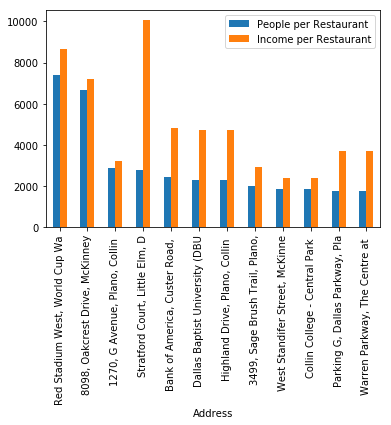

In [31]:
cluster_all.plot(kind='bar',x='Address',y=['People per Restaurant','Income per Restaurant'])

OK. These graphs provide interesting insights on the clusters. 

The top two in Frisco and McKinney clearly stand out as being the most suitable with very high number of people per restaurant(low density) and similar income per restaurant. No suprise on the areas as these are known to be developing and therefore not a lot of restaurants are in operations. These two are clear candidates.

In contrast, more developed areas such as Plano have lower number of people per restaurant (high density) as they have estalished for a longer period in time. We will not considerd the 1270G Avenue as a good candidate as, while it show high people per restaurant ratio, it related income per Restaurant is much lower than the following location candidates.

Last, the next three cluster centres will also make the final cutover list of recommended places becauser their combination of Income and People per Restaurant ratios. We leave the remainder out as they show less favourable combinations

In [29]:
cluster_top = cluster_all.iloc[[0,1,3,4,5,6],:]
cluster_top

,Address,latitude,longitude,ZIP,Population,Median-Income,Restaurant,Venue,People per Restaurant,Income per Restaurant
1,"Red Stadium West, World Cup Wa",33.156902,-96.838496,75034,95996.0,112626.0,13,30,7384.307692,8663.538462
7,"8098, Oakcrest Drive, McKinney",33.190316,-96.722366,75070,93299.0,100848.0,14,47,6664.214286,7203.428571
10,"Stratford Court, Little Elm, D",33.160606,-96.900746,75036,33245.0,120701.0,12,44,2770.416667,10058.416667
0,"Bank of America, Custer Road,",33.127015,-96.732617,75025,53559.0,106301.0,22,54,2434.500000,4831.863636
2,Dallas Baptist University (DBU,33.038672,-96.831319,75093,48021.0,99378.0,21,63,2286.714286,4732.285714
3,"Highland Drive, Plano, Collin",33.029622,-96.790684,75093,48021.0,99378.0,21,63,2286.714286,4732.285714


Finally, we visualize our top 6 picks for ideal Restaurant locations in the map along with the other clusters and venues.

In [30]:
# create map
map_clusters = folium.Map(location=center, zoom_start=11)


# add markers with choices to the map
cluster = 1
for lat, lon in zip(cluster_top['latitude'], cluster_top['longitude']):
    icon=folium.Icon(color='green')
    folium.Marker(
        [lat, lon], 
        icon=folium.Icon(type='info-sign',color='green'),
        popup=folium.Popup('#'+str(cluster), show=True, sticky=True)
        ).add_to(map_clusters) 
    cluster = cluster + 1
# add points with venues and restaurants    
for lat, lng, ven_category, name  in zip(northdallas_venues['Venue Latitude'], northdallas_venues['Venue Longitude'], northdallas_venues['Venue Category'],northdallas_venues['Venue']):
    if 'Restaurant' in ven_category : 
        color = 'red'
    else :
        color = 'blue'
    folium.CircleMarker([lat, lng], popup=name, radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_clusters)
# add markers to the map with clusters
cluster = 0
for lat, lon in zip(clusters['lat'], clusters['lon']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], popup=label, radius=20, color='black', fill=True, fill_color=None,fill_opacity=0.1).add_to(map_clusters)
    cluster = cluster+1 

map_clusters

Confirming expectations. The nothern suburbs offer more opportunities to open a new Restaurant as they are relatively new neighboorhoods that are still being developed.Two of the more established areas in Plano (choice#5&6) also come up but are clearly less favourable as the ones on top of the list. 

### Results and Discussion <a name="results"></a>

The analysis performed demonstrates that not all places are ideal to locate a new restaurant in the growing Northern suburbs of Dallas. The venue data obtained from Foursquare shows that the distribution of business across the area is uneven and there are venue concentrations that need to be taken into account when considering opening a new retail business.

In that respect, the geographical clustering of venues obtained through K-means is enlightening. Several clusters emerge from the analysis and they are not necessarily aligned with purely geographical locations. With that information at hand and the map visualizations, it has become apparent where are the best candidate locations are, at least from a pure business density point of view. These clusters are scattered all across Frisco, Plano and McKinney.

By adding the demographic information to the data mix, we have been able to narrow down the list of locations most suitable to open a new restaurant. These data elements have made clear that the best locations are in the north. The locations are less dense in terms of existing restaurant per person (high Person per Restaurant ratio) and more income per restaurant. In simple terms that means that people have less restaurant choices (less competition) and more money to spend! which made those locations ideal to setup new restaurants. In that respect, two locations in Frisco and McKinney clearly stand out from the rest and are the top picks by far. This comes as no surprise as these norther areas are known to be under development and are some of the most fast-growing places in the whole US.

This analysis is conducted without taking into account other economic viability factors such as availably of commercial spaces, lease prices, etc. However, it proves very good starting point to continue the analysis focused in very specific geographical places determined by the top picks


## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify ideal locations to open a new mid-range restaurant in the Northern suburbs of Dallas (Frisco, McKinney, Plano). Since the transportation context in this part of the country makes it mandatory to access the restaurant by car, we have discarded the restaurant density by physical area in favor of looking for concentration of existing venues as attractors of clients. Our criteria to identify ideal locations have been established as proximity to existing business, restaurant density per person and average income for the residents in the area.
In order to perform the geographical analysis, we have divided the area in zip codes and obtained demographic information.
By means of the Foursquare API, we have been able to gather abundant information of venues in the area in scope. Clustering venues by using K-means clustering has given us the necessary insights to visualize and select the densest venues locations. Last, by using the corresponding demographic information we have been able to single out the most attractive areas in terms of lower restaurant saturation per population and highest income.

The final decision will necessarily involve a physical inspection of the recommended areas as well as other economic factors not considered in this study such as availability of commercial space, lease prices and other viability factors. The availability of more granular data and other sources of information could certainly enrich this analysis and make it much more precise. Nevertheless, the purpose of the project has been accomplished with the existing tools and resources.


End